In [106]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "black" # 21st_year, pieman, slumlordreach, black

MODEL = 'gpt2' 
# BERT: bert-base-uncased, bert-large-uncased
# GPT: gpt2, gpt2-xl, gpt-neo-2.7B

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for TR-aligned tokens in data/stimuli/black/tr_tokens.csv
Loaded 534 TRs.


# Produce Layerwise Activations / Z-Reps

In [107]:
foo.process_stimulus_activations()

/Users/sumers/opt/anaconda3/envs/bert-brains/lib/python3.9/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_lg' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Processing TR 0.

TR 0: Window Stimulus: So I
	 TR stimulus: ['So', 'ĠI']
Processing TR 100.

TR 100: Window Stimulus: market I had ever been in I was excited and I was nervous and so I am trying to get to know the community And so I'm going to every fundraiser and every event I can think of and after one of those events I promise you it was actually here at the Sheldon in St Louis Missouri a young man approached me outside on the sidewalk He was black and he said to me
	 TR stimulus: ['he', 'Ġsaid', 'Ġto', 'Ġme']
Processing TR 200.

TR 200: Window Stimulus: know They got to know now Debate put to a rest So I am now all about town and people are beginning to recognize me just from my voice I'm at the grocery store I'm chasing my kids at the St Louis zoo yelling at them people are recognizing my voice I'm gonna drop another hint on the air I'm enjoying the secret mission And so I described trying to make my mother's
	 TR stimulus: ['make', 'Ġmy', 'Ġmother', "'s"]
Processing TR 300.

TR 

In [108]:
foo.model_name

'gpt2'

In [109]:
N_LAYERS = len(foo.stimulus_df["activations"][0])

for layer in range(0, N_LAYERS-1):

    layer_activations = foo.layer_activations_from_tensor(foo.stimulus_df["activations"], layer)
    layer_mean_embeddings = np.array([l.mean(0).numpy() for l in layer_activations])
    np.save("{}_{}_layer_{}_activations.npy".format(STIMULUS, MODEL, layer), layer_mean_embeddings)
        
    layer_z_reps = foo.layer_activations_from_tensor(foo.stimulus_df["z_reps"], layer)
    layer_mean_z_reps = np.array([l.mean(0).numpy() for l in layer_z_reps])
    np.save("{}_{}_layer_{}_z_representations.npy".format(STIMULUS, MODEL, layer), layer_mean_z_reps)
    
    print("Layer {}: saved mean embeddings {} | z-reps {}".format(layer, 
                                                                  layer_mean_embeddings.shape,
                                                                  layer_mean_z_reps.shape))


layer_glove = foo.layer_activations_from_tensor(foo.stimulus_df["glove"], 0)
np.save("{}_{}_layer_{}_glove.npy".format(STIMULUS, MODEL, 0), layer_glove)

Layer 0: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 1: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 2: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 3: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 4: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 5: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 6: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 7: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 8: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 9: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 10: saved mean embeddings (534, 768) | z-reps (534, 768)
Layer 11: saved mean embeddings (534, 768) | z-reps (534, 768)


In [110]:
ALL_LAYER_REPS = "scp {}_{}_layer_*_activations.npy {}_{}_layer_*_z_representations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/raw_embeddings"

print("SCP all model layers and z-reps to PNI:\n")

print(ALL_LAYER_REPS.format(STIMULUS, MODEL, STIMULUS, MODEL, STIMULUS, MODEL))

SCP all model layers and z-reps to PNI:

scp black_gpt2_layer_*_activations.npy black_gpt2_layer_*_z_representations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/black/gpt2/raw_embeddings


# Produce Attention Vectors
Important question: how many prior tokens should we take for attention metric context?

count    534.000000
mean       3.234082
std        1.945669
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       10.000000
Name: n_transformer_tokens_in_tr, dtype: float64


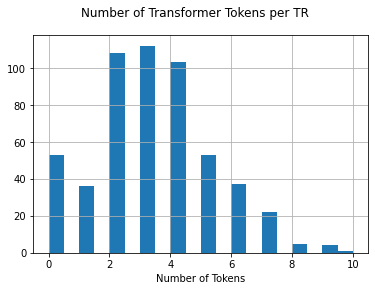

In [111]:
print(foo.stimulus_df.n_transformer_tokens_in_tr.describe())
foo.stimulus_df.n_transformer_tokens_in_tr.hist(bins=20);
plt.suptitle("Number of Transformer Tokens per TR")
plt.xlabel("Number of Tokens");

In [112]:
# Median number of tokens per TR is 5; 75th percentile is 7.
# Assuming we're using about 30 seconds of prior context, that's 20 TRs, so we should take 100-140 context tokens.

N_ATTENTION_TOKENS = 128 # 10, 20, 128

In [113]:
foo.verbose = False
foo.process_stimulus_attentions(num_window_tokens=N_ATTENTION_TOKENS)

Processing TR 0
Processing TR 100
Processing TR 200
Processing TR 300
Processing TR 400
Processing TR 500


In [114]:
print("Successfully produced attention maps for {} of {} TRs.".format( 
    len(foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]), len(foo.stimulus_df)))

Successfully produced attention maps for 494 of 534 TRs.


In [115]:
has_attentions = foo.stimulus_df[foo.stimulus_df.attentions.isnull()]
failed_attentions = foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]

## Mask Attention to produce vectors
def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

All of the below analyses can / should be run with various parameter settings.

They run much faster than the original activation / attention code and do various masking and summarization procedures on the raw data.

In [116]:
def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

In [117]:
DIRECTIONS = ["fwd", "bck"]
NORMS = ["inf"] # can also do p=1 or 2, but not using those currently.

In [118]:
for attention_direction in DIRECTIONS:

    foo.mask_non_tr_attentions(include_forwards=(attention_direction=="fwd"), 
                           include_backwards=(attention_direction=="bck"))


    for p in NORMS:  

        foo.compute_attention_head_magnitudes(p=p)
        attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))
        attention_np_arrays = np.array(attention_vectors)

        complexity_output_file= "{}_{}_syntactic_complexity_L-{}_T-{}_D-{}.npy".format(STIMULUS, MODEL, p, N_ATTENTION_TOKENS, attention_direction)
        np.save(complexity_output_file, attention_np_arrays)
        
        print("Output metrics to {}".format(complexity_output_file))
        print(attention_np_arrays.shape)

Output metrics to black_gpt2_syntactic_complexity_L-inf_T-128_D-fwd.npy
(534,)
Output metrics to black_gpt2_syntactic_complexity_L-inf_T-128_D-bck.npy
(534,)


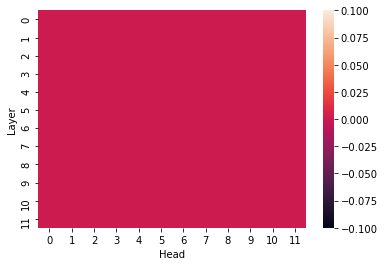

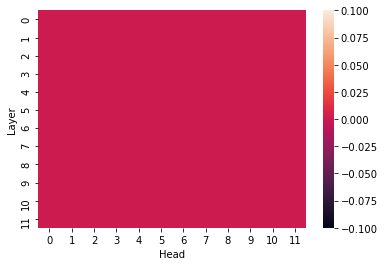

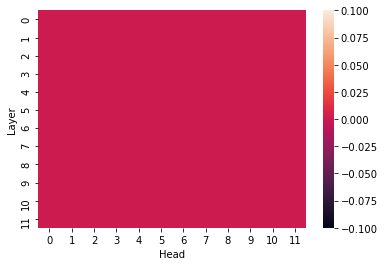

In [119]:
for x in [90, 150, 200]:
    plt.figure()
    sns.heatmap(foo.stimulus_df.attention_heads_Linf.iloc[x])
    plt.xlabel("Head")
    plt.ylabel("Layer")

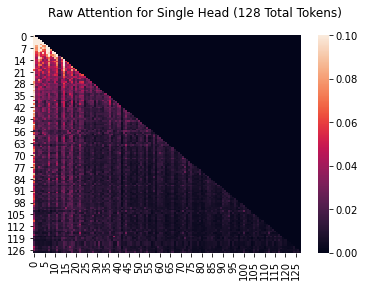

In [120]:
sns.heatmap(foo.stimulus_df.attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("Raw Attention for Single Head ({} Total Tokens)".format(N_ATTENTION_TOKENS));

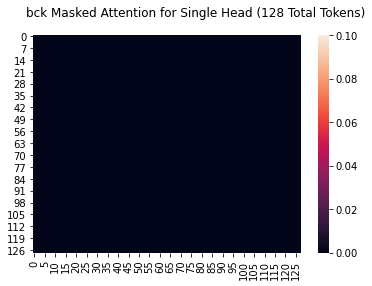

In [121]:
sns.heatmap(foo.stimulus_df.masked_attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("{} Masked Attention for Single Head ({} Total Tokens)".format(attention_direction, N_ATTENTION_TOKENS));

## Output Attention Vector .npy's

In [122]:
def concatenate_fwd_bck_arrays(fwd, bck):

    res = []
    for f, b in zip(fwd, bck):
        if f is None and b is None:
            res.append(None)
        else:                
            res.append(f + b)
    res = np.array(res, dtype=object)
        
    return res

In [123]:
import glob

backwards_metrics = [f for f in glob.glob("*.npy") if 'bck' in f]

for backwards_file in backwards_metrics:
    
    bck = np.load(backwards_file, allow_pickle=True)
    forward_file = backwards_file.replace("bck", "fwd")
    fwd = np.load(forward_file, allow_pickle=True)
    
    concat = concatenate_fwd_bck_arrays(fwd, bck)
    concat_file = backwards_file.replace("bck", "concat")
    
    np.save(concat_file, concat)
    
    print("Concatenated\n===========")
    print("\tFile: {}".format(concat_file))
    print("\tTRs:{}".format(concat.shape[0]))
    print("\tDimensions: {}\n\n".format(len(concat[-1])))

Concatenated
	File: black_bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat.npy
	TRs:534
	Dimensions: 288


Concatenated
	File: black_gpt2_syntactic_complexity_L-inf_T-128_D-concat.npy
	TRs:534
	Dimensions: 288




## SCP to PNI
```scp {FILE_NAME} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{STIMULUS}/{MODEL}/syntactic_analyses```

```ssh tsumers@apps.pni.princeton.edu```

In [124]:
ALL_SYNTAX_REPS = "scp {}_{}_syntactic_*_concat.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/syntactic_analyses"

print("SCP all syntactic representations to PNI:\n")
print(ALL_SYNTAX_REPS.format(STIMULUS, MODEL, STIMULUS, MODEL, STIMULUS, MODEL))

SCP all syntactic representations to PNI:

scp black_gpt2_syntactic_*_concat.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/black/gpt2/syntactic_analyses


# Compare old / new versions of metrics

In [131]:
snapshot_metrics = [f for f in glob.glob("*.npy") if 'snapshot' in f]

for s in snapshot_metrics:

    snapshot = np.load(s, allow_pickle=True)
    new_file = s.split('snapshot-')[-1]
    
    try:
        new = np.load(new_file, allow_pickle=True)
    except FileNotFoundError:
        print("\nERROR: could not load {}".format(new_file))
        continue
    
    print("\n{}".format(new_file))
    print("\tShape: {}".format((snapshot.shape==new.shape)))
    try:
        print("\tClose: {}".format(np.allclose(snapshot, new)))
    except:
        pass
    print("\tComparison of TR 50 reps:")
    print("\t\tOld: {}".format(snapshot[50][:5]))
    print("\t\tNew: {}".format(new[50][:5]))


black_bert-base-uncased_layer_3_activations.npy
	Shape: True
	Close: False
	Comparison of TR 50 reps:
		Old: [0.1494145  0.10405736 0.0247682  0.27294868 0.4291882 ]
		New: [0.1494146  0.10405757 0.02476805 0.27294868 0.4291881 ]

black_bert-base-uncased_layer_3_z_representations.npy
	Shape: True
	Close: False
	Comparison of TR 50 reps:
		Old: [-0.09045324  0.23002855 -0.01164924  0.2281506   0.17834882]
		New: [-0.09045326  0.23002838 -0.01164918  0.22815052  0.17834869]

black_gpt2_layer_3_z_representations.npy
	Shape: True
	Close: False
	Comparison of TR 50 reps:
		Old: [ 0.26421145 -0.24829331 -0.01065088  0.03203887  0.24031702]
		New: [ 0.26421133 -0.24829336 -0.01065074  0.03203896  0.24031727]

black_bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat.npy
	Shape: True
	Comparison of TR 50 reps:
		Old: [0.042980827391147614, 0.14423677325248718, 0.4857538640499115, 0.5327985286712646, 0.05053185299038887]
		New: [0.04298081248998642, 0.14423662424087524, 0.4857539832592